In [159]:
import torch
import torchvision
import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=r'C:\Users\777\PycharmProjects\uchuneyronki\NN\MNIST\CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root=r'C:\Users\777\PycharmProjects\uchuneyronki\NN\MNIST\CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


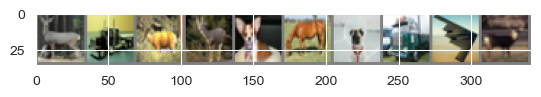

 deer truck  deer  deer   dog horse   dog truck plane  deer


In [160]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images

imshow(torchvision.utils.make_grid(images[:10], nrow=10))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))


In [53]:
for im, mark in train_dataloader:
    print(im.shape)
    break

torch.Size([64, 3, 32, 32])


In [54]:
total = 0
dic_count = {i: 0 for i in range(10)}
dic_graph = {}

In [55]:
print(len(trainset))
print((len(testset)))

50000
10000


Датасет представляет собой набор картинок из 10 классов размером 32х32х3, где 3- количество цветовых фильтров, то есть RGB. Всего 50000 картинок для тренировочной выборки и 10000 для тестовой.

In [7]:
for dat in trainset:
    tens, mark = dat
    dic_count[int(mark)] += 1
    total += 1
tg = 0
for k,v in dic_count.items():
    print(f'Процентоное соотношение класса {classes[tg]} от общего кол-ва цифр: {v*100/total}%')
    dic_graph[classes[tg]]=v
    tg += 1


Процентоное соотношение класса plane от общего кол-ва цифр: 10.0%
Процентоное соотношение класса car от общего кол-ва цифр: 10.0%
Процентоное соотношение класса bird от общего кол-ва цифр: 10.0%
Процентоное соотношение класса cat от общего кол-ва цифр: 10.0%
Процентоное соотношение класса deer от общего кол-ва цифр: 10.0%
Процентоное соотношение класса dog от общего кол-ва цифр: 10.0%
Процентоное соотношение класса frog от общего кол-ва цифр: 10.0%
Процентоное соотношение класса horse от общего кол-ва цифр: 10.0%
Процентоное соотношение класса ship от общего кол-ва цифр: 10.0%
Процентоное соотношение класса truck от общего кол-ва цифр: 10.0%


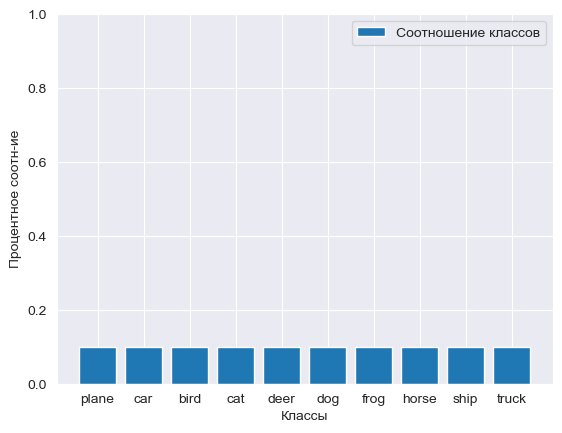

In [8]:
keys = dic_graph.keys()
vals = dic_graph.values()
plt.bar(keys, np.divide(list(vals), sum(vals)), label="Соотношение классов")
plt.ylim(0,1)
plt.ylabel("Процентное соотн-ие")
plt.xlabel("Классы")
plt.xticks(list(keys))
plt.legend()
plt.show()

Тренировочная выборка хорошо сбалансирована: по 5000 элементов для каждого класса

In [126]:
class Net_mlp(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(3*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

In [127]:
batch_size = 64
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = Net_mlp().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Using cuda device


In [128]:
print(model)

Net_mlp(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [129]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 1024]       3,146,752
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
       BatchNorm1d-5                  [-1, 512]           1,024
              ReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
       BatchNorm1d-8                  [-1, 256]             512
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 3,806,986
Trainable params: 3,806,986
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 14.52
Estima

Архитектура сети имеет 3072 входа, то есть изображение 32х32 в 3ех каналах. В качестве функции активации была использована ReLu
![image](ReLUpic.jpg)
Затем идет слой из 1024, 512, 256, 128 и 10 выходных нейронов соответственно.

In [130]:
def train_loop(dataloader, model, loss_function, optimizer):
    global cortrain
    num_batches = len(dataloader)

    train_loss, corr_train = 0, 0
    cortrain = []

    for imgs, labels in dataloader:
        # предсказание и расчет потерь
        pred = model(imgs.to(device).view(-1,32*32*3))
        loss = loss_function(pred, labels.to(device))

        # оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        corr_train += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )
    cortrain = corr_train* 100
    train_loss /= num_batches
    print(f"Потери обучения: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, loss_function):
    global cortest
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0
    cortest = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device).view(-1,32*32*3))
            loss = loss_function(pred, labels.to(device))

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )
    cortest = correct * 100
    test_loss /= num_batches
    correct /= size
    print(f"Потери на тестовых данных: {test_loss:>8f}, Точность модели на тестовых данных: {(100*correct):>0.1f}% \n")

    return test_loss

In [131]:
loss_history = {"train": [], "test": []}
start_time = time.time()
num_epochs = 7
cor_test = []
cor_train = []
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, model, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_function)
    cor_test.append(cortest)
    cor_train.append(cortrain)
    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1
Потери обучения: 1.606656
Потери на тестовых данных: 1.461731, Точность модели на тестовых данных: 48.0% 

Эпоха номер 2
Потери обучения: 1.378925
Потери на тестовых данных: 1.368878, Точность модели на тестовых данных: 50.8% 

Эпоха номер 3
Потери обучения: 1.262787
Потери на тестовых данных: 1.332566, Точность модели на тестовых данных: 53.0% 

Эпоха номер 4
Потери обучения: 1.170727
Потери на тестовых данных: 1.321401, Точность модели на тестовых данных: 53.1% 

Эпоха номер 5
Потери обучения: 1.084165
Потери на тестовых данных: 1.285651, Точность модели на тестовых данных: 55.1% 

Эпоха номер 6
Потери обучения: 1.002891
Потери на тестовых данных: 1.303841, Точность модели на тестовых данных: 54.7% 

Эпоха номер 7
Потери обучения: 0.920752
Потери на тестовых данных: 1.302012, Точность модели на тестовых данных: 55.6% 

Обучение завершнео за 7 эпох, затраченное время: 54.243 секунд


In [132]:
cor_test_g = [x / 10000 for x in cor_test]
cor_train_g = [x / 60000 for x in cor_train]

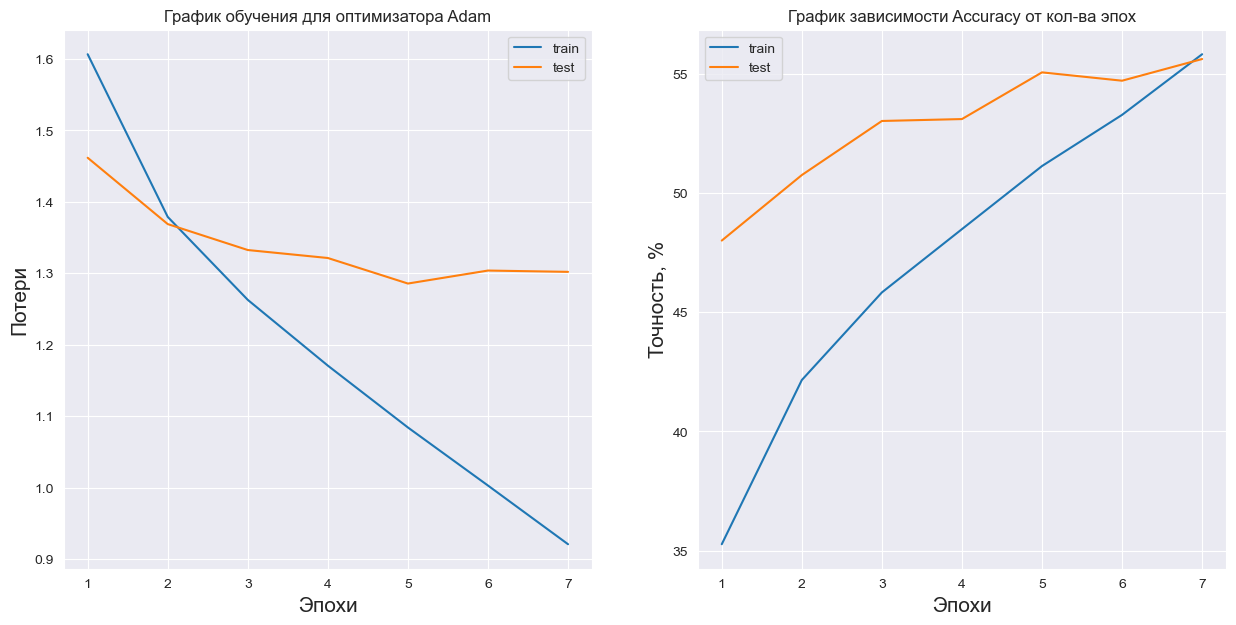

In [133]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.title("График обучения для оптимизатора Adam")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), cor_train_g, label="train")
plt.plot(range(1, num_epochs + 1), cor_test_g, label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Точность, %", fontsize=15)
plt.legend()
plt.title("График зависимости Accuracy от кол-ва эпох")
plt.grid
plt.show()

Практика показала, что модель с такой архитектурой не способна показывать точность выше 56+-0.8%. Как видно на графиках train и test accuracy сошлись. Train и test loss начинают сильно расходится, что приведет к переобучению и снижению точности, поэтому продолжать обучать модель на большем количестве эпох смысла нет. Цель этого этапа: показать, что многослойной персептрон способен классифицировать сложные изображения, пусть и не очень точно.

In [134]:
net = model.to('cpu')
y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        X, y = data
        output = net(X.view(-1, 3072))
        y_true += y.tolist()
        y_pred += torch.argmax(output, dim=1).tolist()
        for idx, i in enumerate(output):
             if torch.argmax(i) == y[idx]:
                 correct += 1
             total += 1
print(f'Accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)}%')
print(f'Precision score: {round(precision_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'Recall score: {round(recall_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'f1 score: {round(f1_score(y_true, y_pred, average="macro")*100, 2)}%')

Accuracy: 55.63%
Precision score: 55.3%
Recall score: 55.63%
f1 score: 55.32%


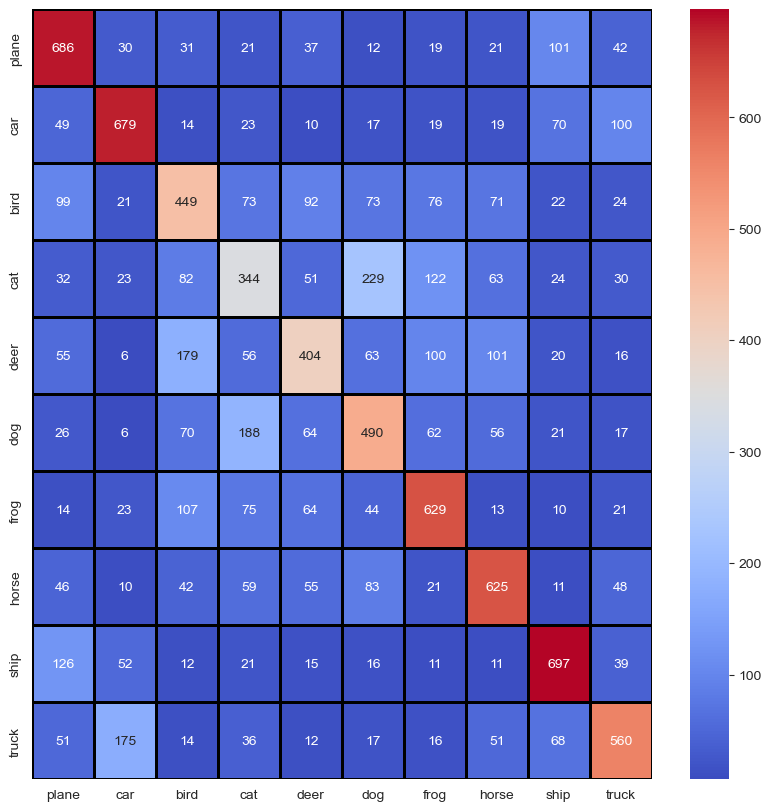

In [135]:
plt.figure(figsize=(10,10))
sb.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='coolwarm', linewidths=2, linecolor='black',fmt=str(), xticklabels=classes, yticklabels=classes)
plt.show()

In [139]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      1000
           1       0.66      0.68      0.67      1000
           2       0.45      0.45      0.45      1000
           3       0.38      0.34      0.36      1000
           4       0.50      0.40      0.45      1000
           5       0.47      0.49      0.48      1000
           6       0.59      0.63      0.61      1000
           7       0.61      0.62      0.62      1000
           8       0.67      0.70      0.68      1000
           9       0.62      0.56      0.59      1000

    accuracy                           0.56     10000
   macro avg       0.55      0.56      0.55     10000
weighted avg       0.55      0.56      0.55     10000



In [137]:
imgs, labels = next(iter(test_dataloader))
pred = model(imgs)
imgs = torch.reshape(imgs, (64, 3, 32, 32))
imgs = imgs[:64]
pred = pred[:64].detach()
digits = np.argmax(pred.cpu().numpy(), axis=1)
lb = labels.numpy()

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
  cat       ship      plane      plane       deer       frog        car       frog
                                    Реальные классы:
  cat       ship       ship      plane       frog       frog        car       frog


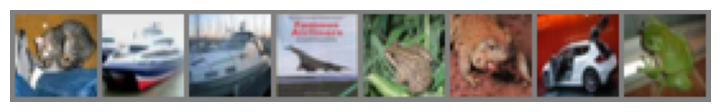

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 bird        car      plane        car        dog      horse        car       ship
                                    Реальные классы:
  cat        car      plane      truck        dog      horse      truck       ship


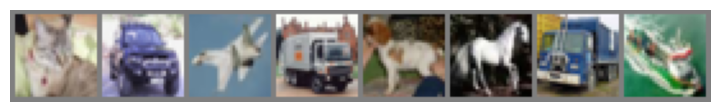

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
  dog        dog       ship       frog      truck      plane       bird      truck
                                    Реальные классы:
  dog      horse       ship       frog      horse      plane       deer      truck


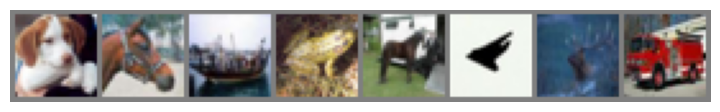

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 deer       bird        dog      plane      truck       frog       frog       deer
                                    Реальные классы:
  dog       bird       deer      plane      truck       frog       frog        dog


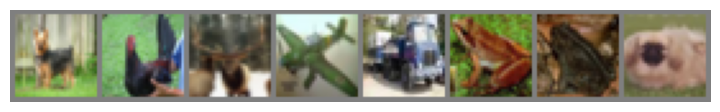

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 deer        dog      truck        car       frog       ship        car        dog
                                    Реальные классы:
 deer        dog      truck       bird       deer        car      truck        dog


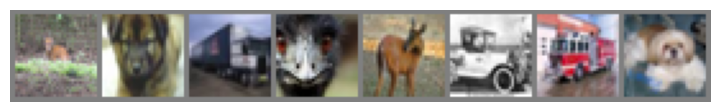

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
plane       frog        cat        dog      plane      truck       bird        cat
                                    Реальные классы:
 deer       frog        dog       frog      plane      truck        cat      truck


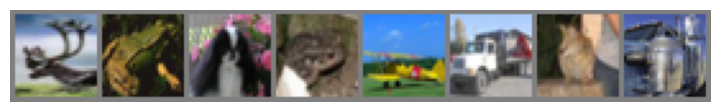

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
horse       bird      truck      plane       frog        cat       ship       ship
                                    Реальные классы:
horse       frog      truck       ship      plane        cat       ship       ship


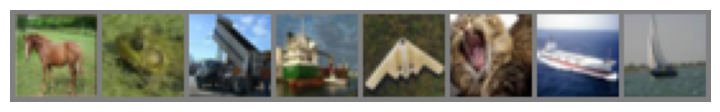

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
horse       frog        cat       bird      horse        cat        car        cat
                                    Реальные классы:
horse      horse       deer       frog      horse        cat       frog        cat


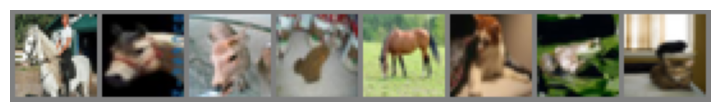

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.


In [138]:
print('._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.')
for k in range(1,9):
    images = imgs[((k-1)*8):(k*8)]
    digts = digits[((k-1)*8):(k*8)]
    lbls = lb[((k-1)*8):(k*8)]
    figure = plt.figure(figsize=(85,95))
    plt.subplot(1, 8, k)
    plt.axis("off")
    print("                                     Предсказание")
    print('      '.join('%5s' % classes[digts[j]] for j in range(8)))
    print("                                    Реальные классы:")
    print('      '.join('%5s' % classes[lbls[j]] for j in range(8)))
    imshow(torchvision.utils.make_grid(images[:8], nrow=10))
    print('._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.')

Как видно из полученных результатов, архитектура ИНС на многослойном персептроне способна классифицировать изображения, но точность невысока.

# Сверточная ИНС

In [106]:
def train_loop(dataloader, model, loss_function, optimizer):
    global cortrain
    num_batches = len(dataloader)

    train_loss, corr_train = 0, 0
    cortrain = []

    for imgs, labels in dataloader:
        # предсказание и расчет потерь
        pred = model(imgs.to(device))
        loss = loss_function(pred, labels.to(device))

        # оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        corr_train += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )
    cortrain = corr_train* 100
    train_loss /= num_batches
    print(f"Потери обучения: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, loss_function):
    global cortest
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0
    cortest = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device))
            loss = loss_function(pred, labels.to(device))

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )
    cortest = correct * 100
    test_loss /= num_batches
    correct /= size
    print(f"Потери на тестовых данных: {test_loss:>8f}, Точность модели на тестовых данных: {(100*correct):>0.1f}% \n")

    return test_loss

In [92]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.MaxPool2d(2), # 16 x 16 x 64
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.MaxPool2d(2), #8 x 8 x 32
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.Dropout(0.8),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return x
model_cnn = CNN_model().to(device)

Архитектура сети имеет следующий вид:
![image](cnar.png)

In [93]:
print(model_cnn)

CNN_model(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [94]:
summary(model_cnn, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
         MaxPool2d-9           [-1, 64, 16, 16]               0
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

Количество рассчитываемых параметров меньше, чем в многослойном персептроне

In [95]:
num_epochs = 17
batch_size = 64
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [96]:
model_cnn = CNN_model().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)


In [97]:
loss_history = {"train": [], "test": []}
start_time = time.time()
cor_test = []
cor_train = []
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, model_cnn, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, model_cnn, loss_function)
    cor_test.append(cortest)
    cor_train.append(cortrain)
    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1
Потери обучения: 1.650011
Потери на тестовых данных: 1.448878, Точность модели на тестовых данных: 46.4% 

Эпоха номер 2
Потери обучения: 1.282263
Потери на тестовых данных: 1.167516, Точность модели на тестовых данных: 58.3% 

Эпоха номер 3
Потери обучения: 1.050614
Потери на тестовых данных: 0.976881, Точность модели на тестовых данных: 64.8% 

Эпоха номер 4
Потери обучения: 0.909565
Потери на тестовых данных: 0.893391, Точность модели на тестовых данных: 69.0% 

Эпоха номер 5
Потери обучения: 0.816845
Потери на тестовых данных: 0.852598, Точность модели на тестовых данных: 70.6% 

Эпоха номер 6
Потери обучения: 0.729384
Потери на тестовых данных: 0.752826, Точность модели на тестовых данных: 74.0% 

Эпоха номер 7
Потери обучения: 0.659675
Потери на тестовых данных: 0.699932, Точность модели на тестовых данных: 76.0% 

Эпоха номер 8
Потери обучения: 0.585848
Потери на тестовых данных: 0.646689, Точность модели на тестовых данных: 78.0% 

Эпоха номер 9
Потери обучения: 0

In [98]:
cor_test_g = [x / 10000 for x in cor_test]
cor_train_g = [x / 60000 for x in cor_train]

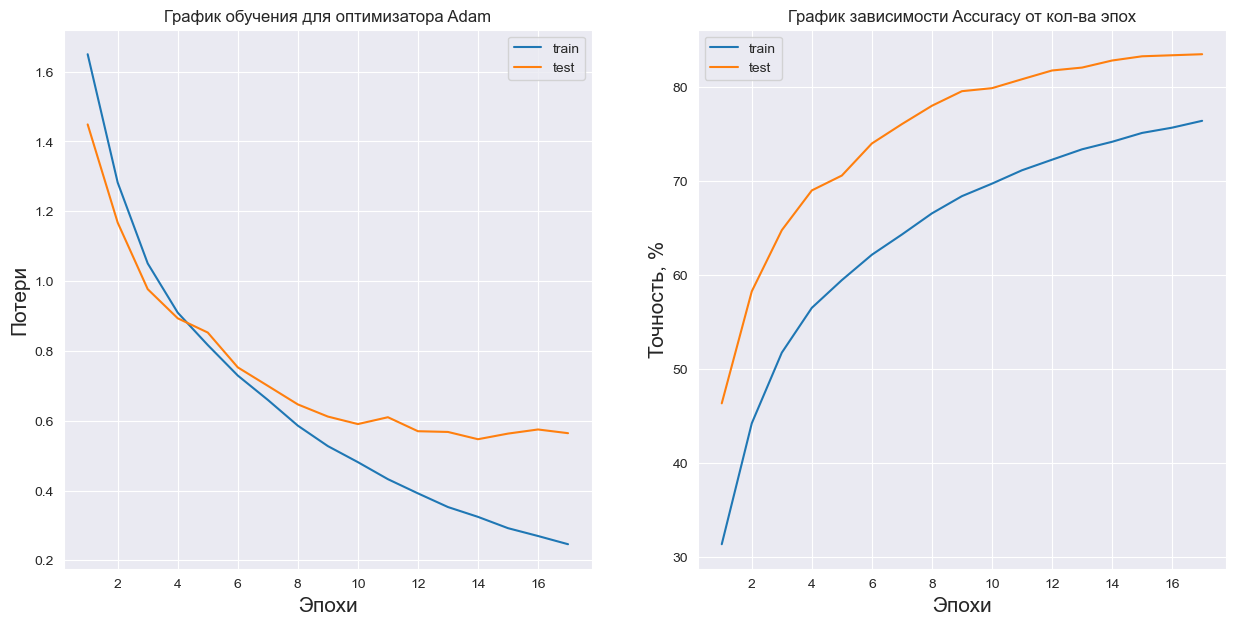

In [99]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.title("График обучения для оптимизатора Adam")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), cor_train_g, label="train")
plt.plot(range(1, num_epochs + 1), cor_test_g, label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Точность, %", fontsize=15)
plt.legend()
plt.title("График зависимости Accuracy от кол-ва эпох")
plt.grid
plt.show()

Хоть графики Accuracy не сошлись, но практика показывает, что при продолжении обучения наблюдается переобучение и снижение точности. Также это можно посмотреть на графиках Train loss, что при увеличении кол-ва эпох растет и переобучение.

In [101]:
net = model_cnn.to('cpu')
y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        X, y = data
        output = net(X)
        y_true += y.tolist()
        y_pred += torch.argmax(output, dim=1).tolist()
        for idx, i in enumerate(output):
             if torch.argmax(i) == y[idx]:
                 correct += 1
             total += 1
print(f'Accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)}%')
print(f'Precision score: {round(precision_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'Recall score: {round(recall_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'f1 score: {round(f1_score(y_true, y_pred, average="macro")*100, 2)}%')

Accuracy: 83.38%
Precision score: 83.33%
Recall score: 83.38%
f1 score: 83.31%


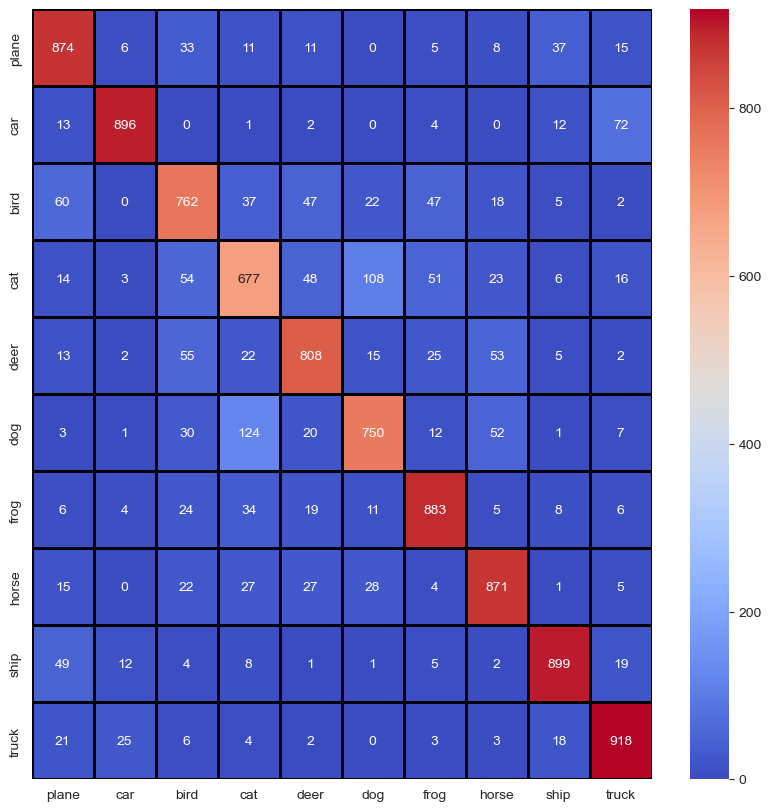

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"
plt.figure(figsize=(10,10))
sb.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='coolwarm', linewidths=2, linecolor='black', fmt=str(), xticklabels=classes, yticklabels=classes)
plt.show()

In [122]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1000
           1       0.94      0.90      0.92      1000
           2       0.77      0.76      0.77      1000
           3       0.72      0.68      0.70      1000
           4       0.82      0.81      0.81      1000
           5       0.80      0.75      0.78      1000
           6       0.85      0.88      0.87      1000
           7       0.84      0.87      0.86      1000
           8       0.91      0.90      0.90      1000
           9       0.86      0.92      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [123]:
imgs, labels = next(iter(test_dataloader))
pred = model_cnn(imgs)
imgs = torch.reshape(imgs, (64, 3, 32, 32))
imgs = imgs[:64]
pred = pred[:64].detach()
digits = np.argmax(pred.cpu().numpy(), axis=1)
lb = labels.numpy()

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
  cat       ship       ship      plane       frog       frog        car       bird
                                    Реальные классы:
  cat       ship       ship      plane       frog       frog        car       frog


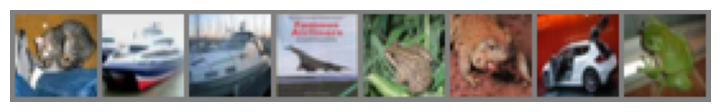

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
  cat        car      plane      truck        dog      horse      truck      plane
                                    Реальные классы:
  cat        car      plane      truck        dog      horse      truck       ship


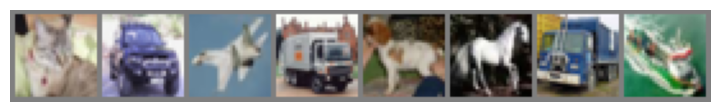

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
  dog      horse       ship       frog      horse      plane       deer      truck
                                    Реальные классы:
  dog      horse       ship       frog      horse      plane       deer      truck


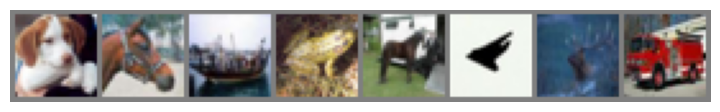

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 deer       bird       deer      plane      truck       frog       frog        dog
                                    Реальные классы:
  dog       bird       deer      plane      truck       frog       frog        dog


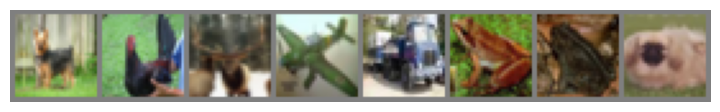

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 deer       frog      truck        cat       deer      truck      truck        dog
                                    Реальные классы:
 deer        dog      truck       bird       deer        car      truck        dog


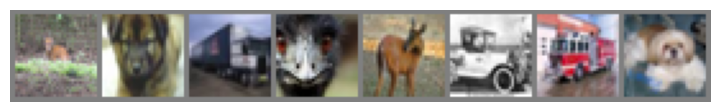

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 deer       frog       bird       frog      plane      truck        cat       ship
                                    Реальные классы:
 deer       frog        dog       frog      plane      truck        cat      truck


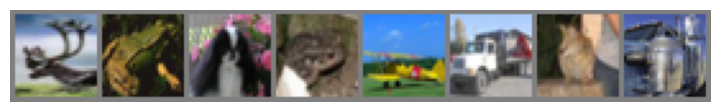

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
horse       frog      truck       ship      horse        dog       ship       ship
                                    Реальные классы:
horse       frog      truck       ship      plane        cat       ship       ship


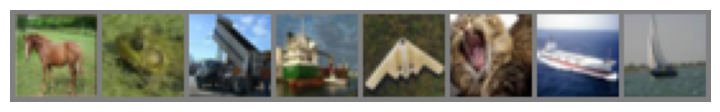

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
horse        cat      horse        cat      horse        dog       frog        cat
                                    Реальные классы:
horse      horse       deer       frog      horse        cat       frog        cat


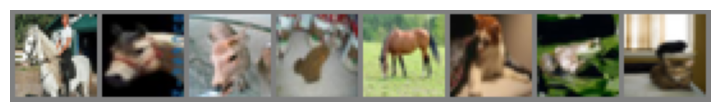

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.


In [124]:
print('._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.')
for k in range(1,9):
    images = imgs[((k-1)*8):(k*8)]
    digts = digits[((k-1)*8):(k*8)]
    lbls = lb[((k-1)*8):(k*8)]
    figure = plt.figure(figsize=(85,95))
    plt.subplot(1, 8, k)
    plt.axis("off")
    print("                                     Предсказание")
    print('      '.join('%5s' % classes[digts[j]] for j in range(8)))
    print("                                    Реальные классы:")
    print('      '.join('%5s' % classes[lbls[j]] for j in range(8)))
    imshow(torchvision.utils.make_grid(images[:8], nrow=10))
    print('._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.')

Сверточная ИНС справляется гораздо лучше, способна классифицировать "сложные" изображение и имеет точность в 83.4%

# Своя ResNet

In [144]:
class myresn(nn.Module):
    def __init__(self):
        super(myresn, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        self.resblock1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)),
            nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)))

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))

        self.resblock2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True)),
            nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True)))

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))

        self.resblock3 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.Dropout(0.9),
            nn.ReLU(inplace=True)),
            nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.Dropout(0.9),
            nn.ReLU(inplace=True)))


        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.Dropout(0.8),
            nn.ReLU(inplace=True))

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.resblock1(x) + x
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.resblock2(x) + x
        x = self.conv6(x)
        x = self.resblock3(x) + x
        x = self.conv7(x)
        x = self.classifier(x)

        return x

In [145]:
myres_model = myresn().to(device)

In [146]:
myres_model

myresn(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (resblock1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [147]:
summary(myres_model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [148]:
num_epochs = 15
batch_size = 64
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

In [149]:
myres_model = myresn().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(myres_model.parameters(), lr=learning_rate)


In [150]:
loss_history = {"train": [], "test": []}
start_time = time.time()
cor_test = []
cor_train = []
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, myres_model, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, myres_model, loss_function)
    cor_test.append(cortest)
    cor_train.append(cortrain)
    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1
Потери обучения: 1.649250
Потери на тестовых данных: 1.323712, Точность модели на тестовых данных: 51.1% 

Эпоха номер 2
Потери обучения: 1.100003
Потери на тестовых данных: 1.041868, Точность модели на тестовых данных: 63.7% 

Эпоха номер 3
Потери обучения: 0.855347
Потери на тестовых данных: 0.822626, Точность модели на тестовых данных: 71.3% 

Эпоха номер 4
Потери обучения: 0.713415
Потери на тестовых данных: 0.726062, Точность модели на тестовых данных: 75.0% 

Эпоха номер 5
Потери обучения: 0.597386
Потери на тестовых данных: 0.643770, Точность модели на тестовых данных: 78.6% 

Эпоха номер 6
Потери обучения: 0.517423
Потери на тестовых данных: 0.582124, Точность модели на тестовых данных: 80.7% 

Эпоха номер 7
Потери обучения: 0.438950
Потери на тестовых данных: 0.564714, Точность модели на тестовых данных: 81.8% 

Эпоха номер 8
Потери обучения: 0.375397
Потери на тестовых данных: 0.545005, Точность модели на тестовых данных: 82.2% 

Эпоха номер 9
Потери обучения: 0

In [151]:
cor_test_g = [x / 10000 for x in cor_test]
cor_train_g = [x / 60000 for x in cor_train]

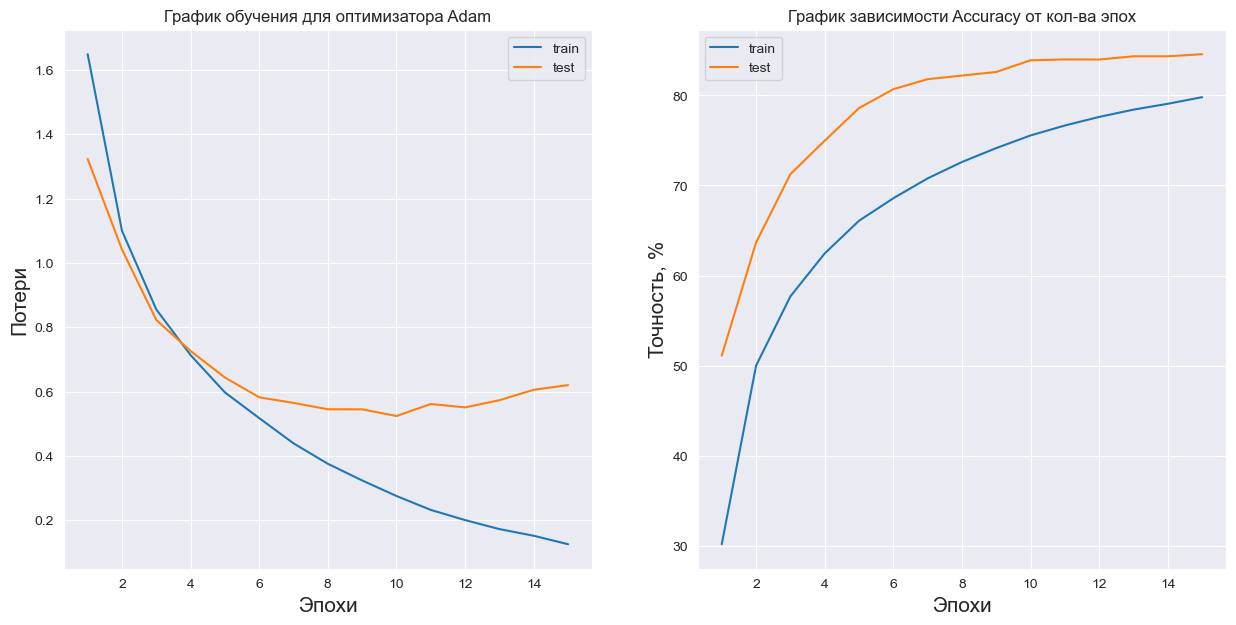

In [152]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.title("График обучения для оптимизатора Adam")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), cor_train_g, label="train")
plt.plot(range(1, num_epochs + 1), cor_test_g, label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Точность, %", fontsize=15)
plt.legend()
plt.title("График зависимости Accuracy от кол-ва эпох")
plt.grid
plt.show()

In [154]:
net = myres_model.to('cpu')
y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        X, y = data
        output = net(X)
        y_true += y.tolist()
        y_pred += torch.argmax(output, dim=1).tolist()
        for idx, i in enumerate(output):
             if torch.argmax(i) == y[idx]:
                 correct += 1
             total += 1
print(f'Accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)}%')
print(f'Precision score: {round(precision_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'Recall score: {round(recall_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'f1 score: {round(f1_score(y_true, y_pred, average="macro")*100, 2)}%')

Accuracy: 84.64%
Precision score: 84.68%
Recall score: 84.64%
f1 score: 84.58%


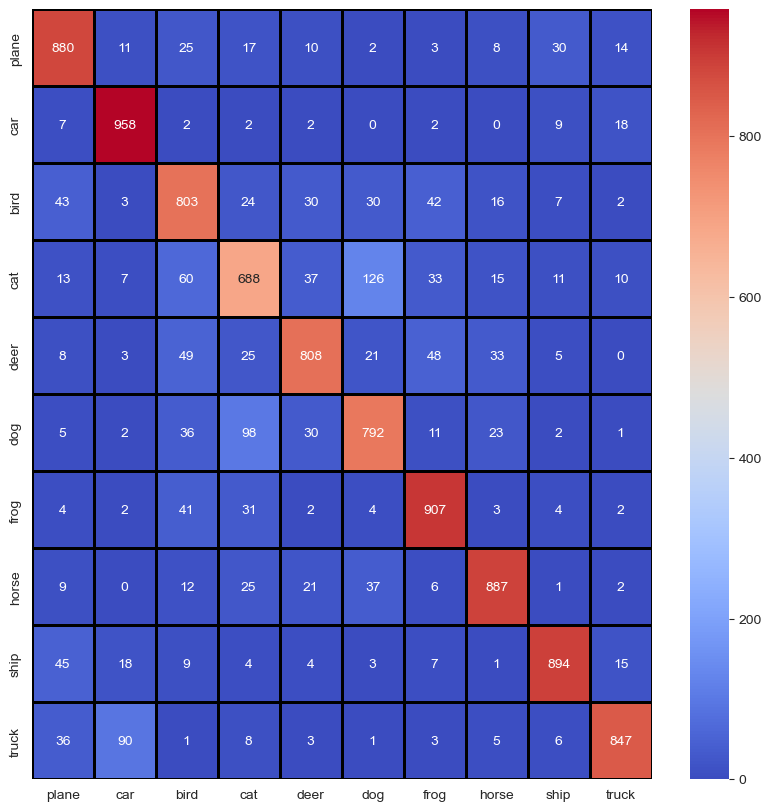

In [155]:
device = "cuda" if torch.cuda.is_available() else "cpu"
plt.figure(figsize=(10,10))
sb.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='coolwarm', linewidths=2, linecolor='black', fmt=str(), xticklabels=classes, yticklabels=classes)
plt.show()

In [156]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.88      0.96      0.91      1000
           2       0.77      0.80      0.79      1000
           3       0.75      0.69      0.72      1000
           4       0.85      0.81      0.83      1000
           5       0.78      0.79      0.79      1000
           6       0.85      0.91      0.88      1000
           7       0.90      0.89      0.89      1000
           8       0.92      0.89      0.91      1000
           9       0.93      0.85      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [157]:
imgs, labels = next(iter(test_dataloader))
pred = myres_model(imgs)
imgs = torch.reshape(imgs, (64, 3, 32, 32))
imgs = imgs[:64]
pred = pred[:64].detach()
digits = np.argmax(pred.cpu().numpy(), axis=1)
lb = labels.numpy()

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
  cat       ship        car      plane       frog       frog        car       frog
                                    Реальные классы:
  cat       ship       ship      plane       frog       frog        car       frog


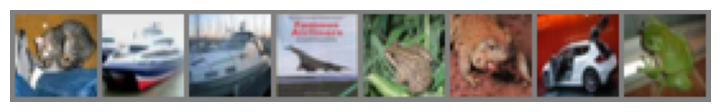

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
  cat        car      plane      truck        dog      horse      truck       ship
                                    Реальные классы:
  cat        car      plane      truck        dog      horse      truck       ship


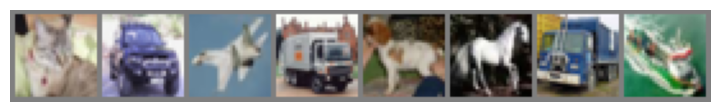

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
  dog      horse       ship       frog        cat      plane       deer      truck
                                    Реальные классы:
  dog      horse       ship       frog      horse      plane       deer      truck


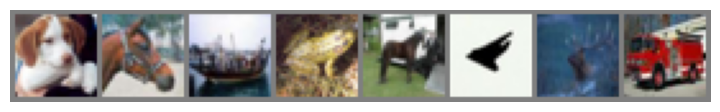

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 deer       bird        dog      plane      truck       frog       bird        dog
                                    Реальные классы:
  dog       bird       deer      plane      truck       frog       frog        dog


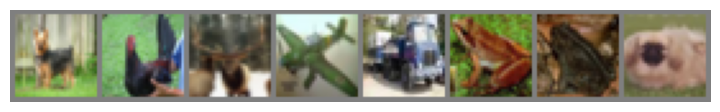

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 deer        dog      truck       ship       deer        car      truck        dog
                                    Реальные классы:
 deer        dog      truck       bird       deer        car      truck        dog


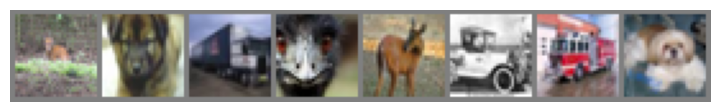

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
 deer       frog        dog       frog      plane      truck        cat      truck
                                    Реальные классы:
 deer       frog        dog       frog      plane      truck        cat      truck


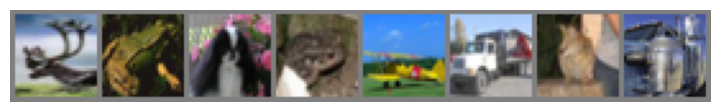

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
horse       frog      truck       ship      horse        dog       ship       ship
                                    Реальные классы:
horse       frog      truck       ship      plane        cat       ship       ship


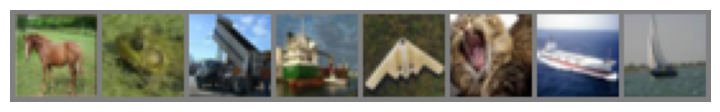

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.
                                     Предсказание
horse        cat       bird       frog      horse        dog       frog        cat
                                    Реальные классы:
horse      horse       deer       frog      horse        cat       frog        cat


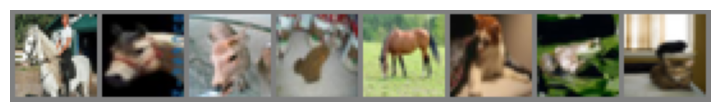

._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.


In [161]:
print('._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.')
for k in range(1,9):
    images = imgs[((k-1)*8):(k*8)]
    digts = digits[((k-1)*8):(k*8)]
    lbls = lb[((k-1)*8):(k*8)]
    figure = plt.figure(figsize=(85,95))
    plt.subplot(1, 8, k)
    plt.axis("off")
    print("                                     Предсказание")
    print('      '.join('%5s' % classes[digts[j]] for j in range(8)))
    print("                                    Реальные классы:")
    print('      '.join('%5s' % classes[lbls[j]] for j in range(8)))
    imshow(torchvision.utils.make_grid(images[:8], nrow=10))
    print('._._._._._._._._._._._._._._._.._._._._._._._._._._._._._._._._._._._._._._._._.._._._.')

# Готовые архитектуры против созданных сетей

In [255]:
import torchvision.models as models

In [256]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# ResNet

In [257]:
model_res= models.resnet18(pretrained=False, num_classes=10).to(device)
model_res.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_res.maxpool = nn.Identity()
model_res = model_res.to(device)

C:\Users\777\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\777\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [258]:
model_res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [259]:
num_epochs = 13
batch_size = 64
learning_rate = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_res.parameters(), lr = learning_rate, weight_decay=5e-4)

Using cuda device


In [260]:
loss_history = {"train": [], "test": []}
start_time = time.time()
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, model_res, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, model_res, loss_function)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1
Потери обучения: 1.265440
Потери на тестовых данных: 0.990838, Точность модели на тестовых данных: 65.0% 

Эпоха номер 2
Потери обучения: 0.857096
Потери на тестовых данных: 0.836425, Точность модели на тестовых данных: 70.3% 

Эпоха номер 3
Потери обучения: 0.701808
Потери на тестовых данных: 0.763925, Точность модели на тестовых данных: 73.7% 

Эпоха номер 4
Потери обучения: 0.602622
Потери на тестовых данных: 0.651899, Точность модели на тестовых данных: 77.4% 

Эпоха номер 5
Потери обучения: 0.528154
Потери на тестовых данных: 0.616759, Точность модели на тестовых данных: 79.1% 

Эпоха номер 6
Потери обучения: 0.465211
Потери на тестовых данных: 0.560955, Точность модели на тестовых данных: 80.9% 

Эпоха номер 7
Потери обучения: 0.412500
Потери на тестовых данных: 0.530179, Точность модели на тестовых данных: 82.1% 

Эпоха номер 8
Потери обучения: 0.375304
Потери на тестовых данных: 0.521334, Точность модели на тестовых данных: 82.5% 

Эпоха номер 9
Потери обучения: 0

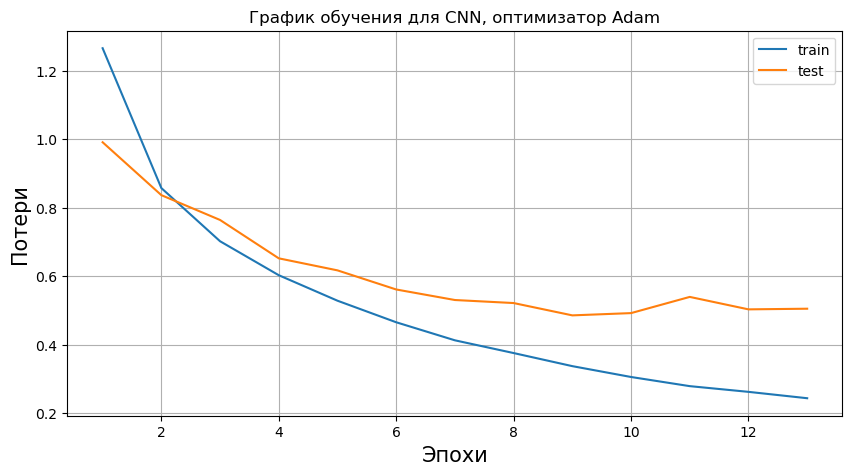

In [261]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.legend()
plt.grid()
plt.title("График обучения для CNN, оптимизатор Adam")
plt.show()

In [262]:
net = model_res.to('cpu')
y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        X, y = data
        output = net(X)
        y_true += y.tolist()
        y_pred += torch.argmax(output, dim=1).tolist()
        for idx, i in enumerate(output):
             if torch.argmax(i) == y[idx]:
                 correct += 1
             total += 1
print(f'Accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)}%')
print(f'Precision score: {round(precision_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'Recall score: {round(recall_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'f1 score: {round(f1_score(y_true, y_pred, average="macro")*100, 2)}%')

Accuracy: 83.6%
Precision score: 83.74%
Recall score: 83.6%
f1 score: 83.59%


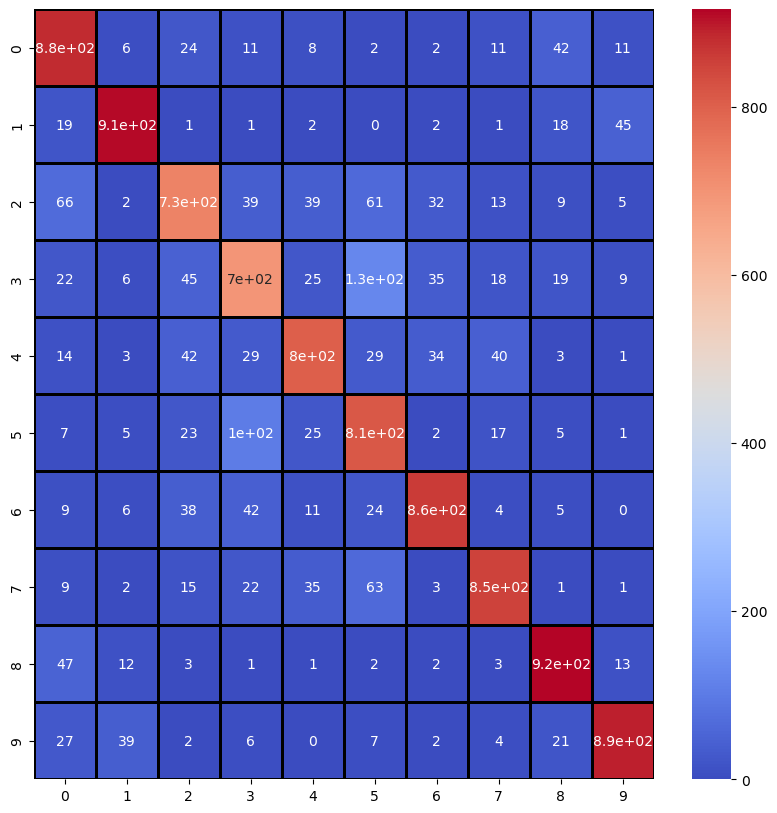

In [263]:
plt.figure(figsize=(10,10))
sb.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='coolwarm', linewidths=2, linecolor='black')
plt.show()

# VGG19

In [264]:
model_vgg= models.vgg19(pretrained=True).to(device)
input_lastLayer = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(input_lastLayer,10)
model_vgg = model_vgg.to(device)

C:\Users\777\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\777\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [265]:
num_epochs = 7
batch_size = 64
learning_rate = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.parameters(), lr = learning_rate,momentum=0.9,  weight_decay=5e-4)

Using cuda device


In [266]:
loss_history = {"train": [], "test": []}
start_time = time.time()
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, model_vgg, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, model_vgg, loss_function)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1
Потери обучения: 0.732029
Потери на тестовых данных: 0.568885, Точность модели на тестовых данных: 80.8% 

Эпоха номер 2
Потери обучения: 0.413934
Потери на тестовых данных: 0.466642, Точность модели на тестовых данных: 84.2% 

Эпоха номер 3
Потери обучения: 0.305694
Потери на тестовых данных: 0.426065, Точность модели на тестовых данных: 86.1% 

Эпоха номер 4
Потери обучения: 0.227469
Потери на тестовых данных: 0.389169, Точность модели на тестовых данных: 87.3% 

Эпоха номер 5
Потери обучения: 0.167643
Потери на тестовых данных: 0.412545, Точность модели на тестовых данных: 87.3% 

Эпоха номер 6
Потери обучения: 0.123107
Потери на тестовых данных: 0.454850, Точность модели на тестовых данных: 87.0% 

Эпоха номер 7
Потери обучения: 0.095319
Потери на тестовых данных: 0.485313, Точность модели на тестовых данных: 87.1% 

Обучение завершнео за 7 эпох, затраченное время: 138.587 секунд


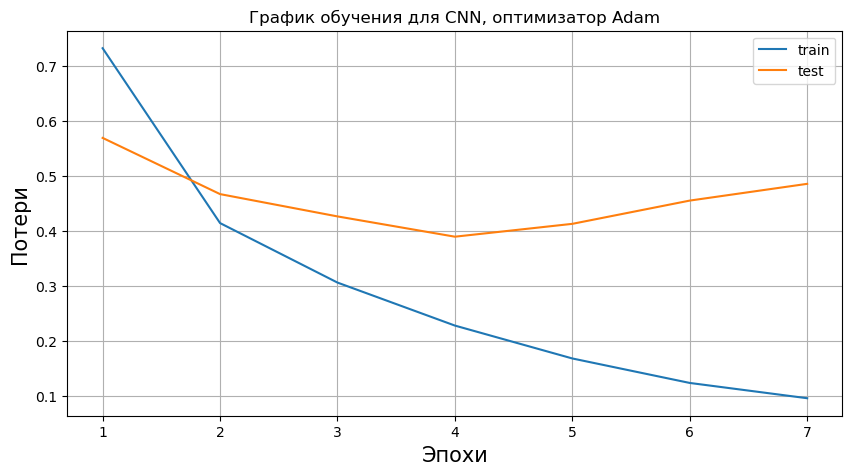

In [267]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.legend()
plt.grid()
plt.title("График обучения для CNN, оптимизатор Adam")
plt.show()

In [268]:
net = model_vgg.to('cpu')
y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        X, y = data
        output = net(X)
        y_true += y.tolist()
        y_pred += torch.argmax(output, dim=1).tolist()
        for idx, i in enumerate(output):
             if torch.argmax(i) == y[idx]:
                 correct += 1
             total += 1
print(f'Accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)}%')
print(f'Precision score: {round(precision_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'Recall score: {round(recall_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'f1 score: {round(f1_score(y_true, y_pred, average="macro")*100, 2)}%')

Accuracy: 86.7%
Precision score: 87.19%
Recall score: 86.7%
f1 score: 86.57%


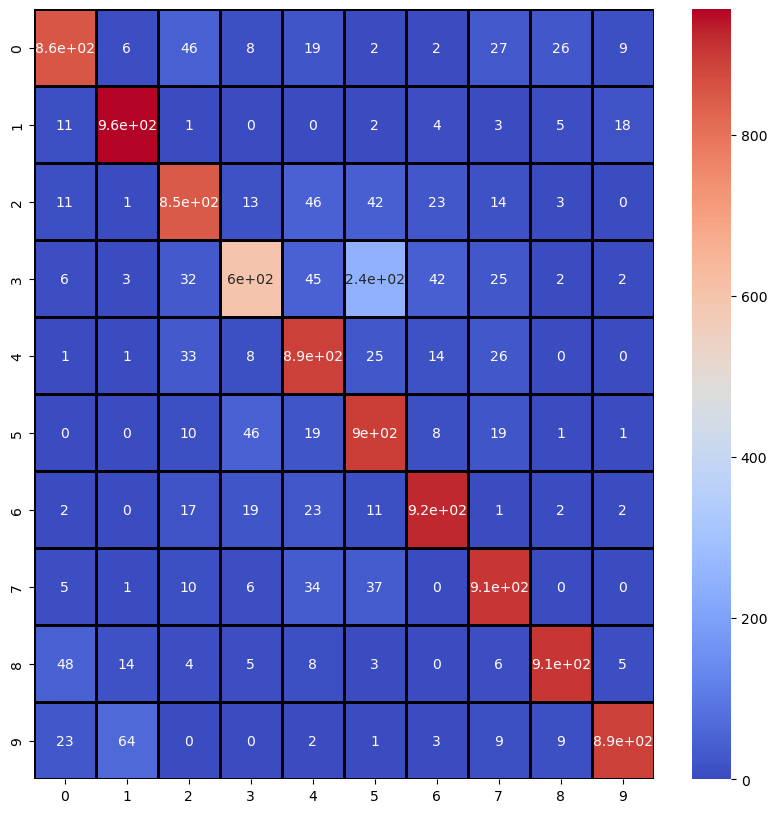

In [269]:
plt.figure(figsize=(10,10))
sb.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='coolwarm', linewidths=2, linecolor='black')
plt.show()